In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#%matplotlib ipympl

import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from IPython.display import IFrame, display, Markdown
plt.style.use('seaborn-talk')
from astropy.io import ascii

In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase
import lsst.geom
import lsst.afw.table as afwTable

DATA ACCESS

In [4]:
# Location of the DC2 Gen3 repository on this site
repo = "/repo/dc2"

# Collection should be the same on all sites
collection='2.2i/runs/DP0.1'

In [5]:
# Create an instance of the butler to get the catalog
butler = dafButler.Butler(repo,collections=collection)

In [6]:
# For the rest of this tutorial, we are going to work with coadd data products
#tract = 4851
#patch = 29   #gen3 analog to gen2 patch id '1,4'
tract = 3828
patch = 32   #gen3 analog to gen2 patch id '1,4'
bandList = ["u", "g", "r", "i", "z", "y"]
filterList = bandList   # using filterList for consistency with cells folllowing below

In [7]:
objects = []
for filter in filterList:
    dataId = {'band':filter, 'tract':tract, 'patch':patch}
    objects.append(butler.get("deepCoadd_forced_src", dataId=dataId))
uSources, gSources, rSources, iSources, zSources, ySources = objects

In [8]:
ySources['coord_ra'][3]

0.9859018300464361

In [9]:
dataId = {'band':filter, 'tract':tract, 'patch':patch}
dcal = butler.get("deepCoadd_calexp", dataId=dataId)
calib = dcal.getPhotoCalib()
print(calib)

spatially constant with mean: 57.544 error: 0


In [10]:
calibs = []
for filter in filterList:
    dataId = {'band':filter, 'tract':tract, 'patch':patch}
    dcal = butler.get("deepCoadd_calexp", dataId=dataId)
    calib = dcal.getPhotoCalib()
    calibs.append(calib)
uCalib, gCalib, rCalib, iCalib, zCalib, yCalib = calibs

In [11]:
type(uCalib)

lsst.afw.image.PhotoCalib

Non-deblended parent sources have deblend_nChild > 0, so we're just looking at deblended objects.
Why are we not using 'detect_isPrimary' instead?
Lee Kelvin: "Currently, for the flag ‘detect_isPrimary’ to be True for any given visit level source, the source must have no deblended children (deblend_nChild == 0) and not be a sky source (sky_source is False). As a reminder, a sky source is a pseudo source injected into the detection list after source detection has taken place, randomly placed such that its footprint does not overlap with any other detected source footprint."

I think modelfit_CModel_flag == True means there is a fit to the source.

base_ClassificationExtendedness_value is 1. for galaxies and 0. for point sources

Finally, set the signal-to-noise ratio to 10

In [12]:
noChildren = iSources['deblend_nChild'] == 0
isGoodFlux = ~iSources['modelfit_CModel_flag']
isStellar = iSources['base_ClassificationExtendedness_value'] >= 1.
snr = iSources['modelfit_CModel_instFlux']/iSources['modelfit_CModel_instFluxErr'] > 10

star_flag = noChildren & isGoodFlux & isStellar & snr

In [13]:
# get a match control, we will keep the default configuration
mc = afwTable.MatchControl()

# match our two catalogs, setting the match threshold to be one arcsecond
matches = afwTable.matchRaDec(uSources[star_flag], iSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

In [14]:
matches2 = afwTable.matchRaDec(gSources[star_flag], iSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

In [15]:
matches3 = afwTable.matchRaDec(rSources[star_flag], iSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

In [16]:
matches4 = afwTable.matchRaDec(zSources[star_flag], iSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

In [17]:
matches5 = afwTable.matchRaDec(ySources[star_flag], iSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

In [18]:
# how many sources were actually matched?
len(matches), len(matches2), len(matches3), len(matches4), len(matches5)

(8814, 8814, 8814, 8814, 8814)

In [19]:
# lets examine the first element in the matches list
# we can grab the record corresponding to this source in the i band catalog
# using the first attribute
#matches[0].first

In [20]:
# likewise the second attribute gives us the record from the r band catalog
#matches[0].second

In [21]:
#finally the angular seperation is given in radians in the distance attribute
matches[0].distance

0.0

In [22]:
# use the calib object to get magnitudes
# pass in a record and the name of the flux field you are interested in
iCalib.instFluxToMagnitude(matches[0].first, 'modelfit_CModel')

Measurement(value=23.42055424262644792, error=0.0277575838035376693)

Text(0, 0.5, '$g, i, y$')

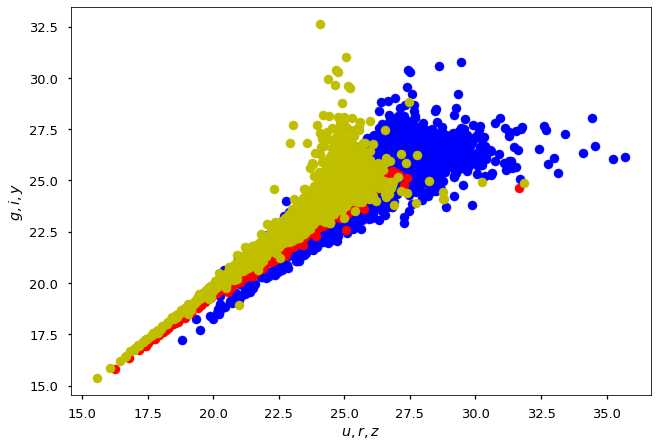

In [23]:
# now we make some loops to grab all the magnitudes in the iband and rband
# remember that the i band catalog is accessed with the first attribute
# and the r band catalog is accessed with the second attribute
uMag = [uCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches]
gMag = [gCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches2]
rMag = [rCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches3]
iMag = [iCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches]
zMag = [zCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches4]
yMag = [yCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches5]

uMag = np.array(uMag)
gMag = np.array(gMag)
rMag = np.array(rMag)
iMag = np.array(iMag)
zMag = np.array(zMag)
yMag = np.array(yMag)

#plt.scatter(np.array(zMag) - (iMag),iMag)
plt.scatter(uMag, gMag, c='b')
plt.scatter(rMag, iMag, c='r')
plt.scatter(zMag, yMag, c='y')
#plt.ylim([-1,4])
#plt.xlim([-1,4])
plt.xlabel('$u, r, z$')
plt.ylabel('$g, i, y$')

In [24]:
len(uMag),len(uSources)

(8814, 31804)